In [1]:
import h5py
import numpy
import numpy as np
import pandas as pd
import scipy.io, scipy.ndimage
import itertools
import scipy.io, scipy.ndimage

#Plotting
import ipympl
from matplotlib import pyplot as plt

#Paths & Files
import pickle as pkl
from pathlib import Path
import os

#Preprocessing/Split/Classifier
import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.discriminant_analysis as skda
import sklearn.preprocessing as skppc
import sklearn.pipeline as skppl
import sklearn.ensemble as skens
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

#Local scripts
from data import DecompData
from features import Raws, Means, Moup, Covariances, AutoCovariances
from plotting import plots
from loading import load_task_data_as_pandas_df
from decomposition import anatomical_parcellation

#Progress Bar
from tqdm.notebook import tqdm

### Load/Extract session data

In [2]:
data_path = Path(os.path.abspath('')).parent / Path('data')
plot_path = Path(os.path.abspath('')).parent / Path('plots')


if (not (data_path/'extracted_data.pkl').exists()):
    # load behavior data
    sessions = load_task_data_as_pandas_df.extract_session_data_and_save(root_paths=[data_path], mouse_ids=["GN06"], reextract=False)
    with open( data_path / 'extracted_data.pkl', 'wb') as handle:
        pkl.dump(sessions, handle)
else:
    # load saved data
    with open( data_path / 'extracted_data.pkl', 'rb') as handle:
        sessions = pkl.load(handle)
    print("Loaded pickled data.")

file_path = data_path / "input" / "GN06" / Path('2021-01-20_10-15-16/SVD_data/Vc.mat')
f = h5py.File(file_path, 'r')

frameCnt = np.array(f['frameCnt'])
trial_starts = np.cumsum(frameCnt[:-1, 1])
svd = DecompData( sessions, np.array(f["Vc"]), np.array(f["U"]), np.array(trial_starts) )

Loaded pickled data.


In [3]:
#alignment
opts_path = data_path / "input" / "GN06" / Path('2021-01-20_10-15-16/SVD_data/opts.mat')

trans_params = scipy.io.loadmat(opts_path,simplify_cells=True)['opts']['transParams']
align_svd = DecompData( sessions, np.array(f["Vc"]), np.array(f["U"]), np.array(trial_starts), trans_params=trans_params)

Min/Max Value: -0.552668035030365 1.0
Rotation
Min/Max Value: -0.4291565858824932 1.0000000000000009
Scale/Zoom
Min/Max Value: -0.41720617943024174 1.0000000000000007
Translate/Shift
Min/Max Value: -0.02101622434157043 1.0000000000000007
Crop


In [7]:
svd = anatomical_parcellation(align_svd) #rename later

#anatomical = DecompData(sessions, temps, spats, np.array(trial_starts))

#svd = anatomical 

(65, 540, 586)
(97450, 65)


### Define Conditions & additional Filters

* Only select trials:
 * with full stimulation (svd.n_targets == 6) and no distractors (svd.n_distractors == 0)
 * out of training phase with no automatic reward (svd.auto_reward == 0) and both choices available (svd.both_spouts == 1)
 
 
* Define conditions as cross-product of:
 * modalities ['visual', 'tactile', 'vistact']
 * side ['right', 'left']

In [8]:
#filter for all conds
trial_preselection = ((svd.n_targets == 6) & (svd.n_distractors == 0) & (svd.auto_reward == 0) & (svd.both_spouts == 1))

#define different conds
modal_keys = ['visual', 'tactile', 'vistact']
side_keys = ['right', 'left']

#set condition filter
cond_keys =  itertools.product(modal_keys,side_keys)
cond_keys_str = [f"{s}_{m}" for m, s in list(cond_keys)]

#apply filter
svd = svd[trial_preselection]
svd.conditions = [{"modality" : modal, "target_side_left" : side} for modal, side in itertools.product(range(len(modal_keys)),range(len(side_keys)))]

### Settings for parcellation and classification 

In [9]:
comp = 65 # Number componants to use
n_rep = 5  # Number of folds

#others
save_outputs = True
baseline_mode = None  #### basline mode ('mean' / 'zscore' / None)
n_comp_LDA = None #5  ### number of LDA componants (conds -1)

### Feature calculation

In [18]:
feature_label = []
feature_data = {

    "mean": [Means.create(svd.conditions[i,:,30:75],max_comps=comp) for i in range(len(svd.conditions))], #mean of stimulusframes for first cond
    #"mean(-base)": [Means(svd.conditions[i,:,30:75]-Means(svd.conditions[i,:,15:30]),comp) for i in range(len(svd.conditions))],
    "raw": [Raws.create(svd.conditions[i,:,30:75],comp) for i in range(len(svd.conditions))], #mean of stimulusframes for first cond,
    #"cov": [Covariances(svd.conditions[i,:,30:75],max_comps=comp) for i in tqdm(range(len(svd.conditions)),desc='Conditions')], #mean of stimulusframes for first cond

}
lag = 3

feature_label = list(feature_data.keys())
for j in tqdm(range(1,lag,1),desc="Time-lags for Cov and MOU-Process"):
    feature_data["Cov(𝜏="+str(j)+")"] =[AutoCovariances.create(svd.conditions[i,:,30:75],max_comps=comp,time_lag_range=[j],label=cond_keys_str[i]) for i in tqdm(range(len(svd.conditions)),desc="Cov(𝜏="+str(j)+")")]   
    feature_label.append(r"Cov($\tau$="+str(j)+")")
    
    '''
    feature_data["Cor(𝜏="+str(j)+")"] =[Correlation.create(svd.conditions[i,:,30:75],max_comps=comp,time_lag_range=[j],label=cond_keys_str[i]) for i in tqdm(range(len(svd.conditions)),desc="Cor(𝜏="+str(j)+")")]   
    feature_label.append(r"Cor($\tau$="+str(j)+")")
    '''
    
    #if j>0:        
        #feature_data["Mou(𝜏="+str(j)+")"] = [Moup.create(svd.conditions[i,:,30:75],max_comps=comp,time_lag=j,label=cond_keys_str[i]) for i in tqdm(range(len(svd.conditions)),desc="Mou(𝜏="+str(j)+")")]
        #feature_label.append(r"Mou($\tau$="+str(j)+")")


Time-lags for Cov and MOU-Process:   0%|          | 0/2 [00:00<?, ?it/s]

Cov(𝜏=1):   0%|          | 0/6 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

Cov(𝜏=2):   0%|          | 0/6 [00:00<?, ?it/s]

right_visual:   0%|          | 0/44 [00:00<?, ?it/s]

left_visual:   0%|          | 0/45 [00:00<?, ?it/s]

right_tactile:   0%|          | 0/76 [00:00<?, ?it/s]

left_tactile:   0%|          | 0/83 [00:00<?, ?it/s]

right_vistact:   0%|          | 0/51 [00:00<?, ?it/s]

left_vistact:   0%|          | 0/56 [00:00<?, ?it/s]

### k-folded Fitting & Evaluating Classifiers 

In [19]:
cv = StratifiedShuffleSplit(n_rep, test_size=0.2, random_state=420)
perf = np.zeros([n_rep, len(feature_data), 4])
classifiers = {}

for i_feat, feat in enumerate(tqdm(feature_data.keys(),desc="Fit & score classifiers",position=0)):
  
    data = np.concatenate([f.flatten() for f in feature_data[feat]])
    labels = np.concatenate( [np.full((len(feature_data[feat][i].flatten())),cond_keys_str[i])
                                for i in range(len(feature_data[feat]))] )
    #feature_labels[feat]
    #for i in range(len(feature_data[feat])):
         #= feature_data[feat][i]



    scaler = preprocessing.StandardScaler().fit( data )
    data = scaler.transform(data)

    cv_split = cv.split(data, labels)

    c_MLR = skppl.make_pipeline(skppc.StandardScaler(),
                                skllm.LogisticRegression(C=1, penalty='l2', multi_class='multinomial',
                                                         solver='lbfgs',
                                                         max_iter=500))
    c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='correlation')

    c_LDA = skda.LinearDiscriminantAnalysis(n_components=n_comp_LDA, solver='eigen', shrinkage='auto')

    c_RF = skens.RandomForestClassifier(n_estimators=100, bootstrap=False)

    classifiers[feat]={"c_MLR":c_MLR.get_params()['steps'][1][1],"c_1NN":c_1NN,"c_LDA":c_LDA,"c_RF":c_RF}

    i = 0  ## counter
    for train_idx, test_idx in tqdm(cv_split,desc=feat,total=n_rep, leave=False, position=1):
        #print(f'\tRepetition {i:>3}/{n_rep}', end="\r" )
        c_MLR.fit(data[train_idx, :], labels[train_idx])
        c_1NN.fit(data[train_idx, :], labels[train_idx])
        c_LDA.fit(data[train_idx, :], labels[train_idx])
        c_RF .fit(data[train_idx, :], labels[train_idx])
        perf[i, i_feat, 0] = c_MLR.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 1] = c_1NN.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 2] = c_LDA.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 3] = c_RF.score(data[test_idx, :], labels[test_idx])
        i += 1
    #print(f'\tRepetition {n_rep:>3}/{n_rep}' )

Fit & score classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

mean:   0%|          | 0/5 [00:00<?, ?it/s]

raw:   0%|          | 0/5 [00:00<?, ?it/s]

E:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cov(𝜏=1):   0%|          | 0/5 [00:00<?, ?it/s]

E:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Cov(𝜏=2):   0%|          | 0/5 [00:00<?, ?it/s]

E:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

### Plotting

Plotting Features:   0%|          | 0/4 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

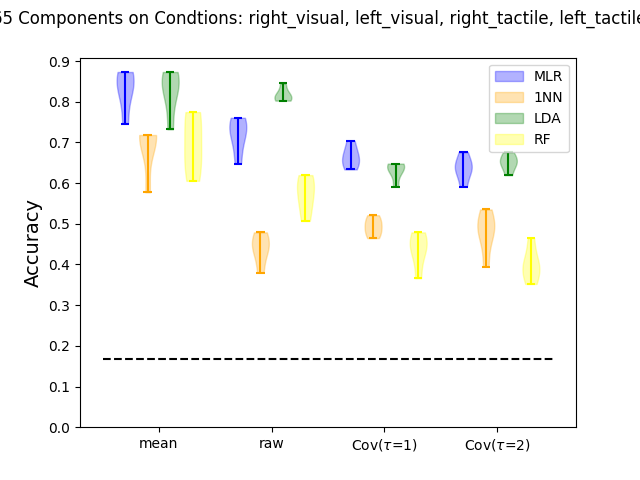

In [20]:
%matplotlib widget

if save_outputs:
    np.save('perf_tasks.npy', perf)
plt.figure()
title = ' '.join(["Classifiers Accuracies","for",str(comp),"Components on Condtions:",', '.join(cond_keys_str)]) #str(len(svd.conditions)),"Conditions"])
plt.suptitle(title)


for i, feat in enumerate(tqdm(feature_data,desc="Plotting Features")):
    v1 = plots.colored_violinplot(perf[:, i, 0], positions=np.arange(1) + i - 0.3, widths=[0.15], color="blue")
    v2 = plots.colored_violinplot(perf[:, i, 1], positions=np.arange(1) + i - 0.1, widths=[0.15], color="orange")
    v3 = plots.colored_violinplot(perf[:, i, 2], positions=np.arange(1) + i + 0.1, widths=[0.15], color="green")
    v4 = plots.colored_violinplot(perf[:, i, 3], positions=np.arange(1) + i + 0.3, widths=[0.15], color="yellow")
    if i == 0:
        plt.legend( [ v['bodies'][0] for v in [v1,v2,v3,v4]], [ "MLR", "1NN", "LDA","RF" ] )


if (not feature_label):
    feature_label = feature_data.keys()

plt.xticks(range(len(feature_label)), [ feat for feat in feature_label ])
plt.plot([-.5, len(feature_label)-.5], [1/len(svd.conditions), 1/len(svd.conditions)], '--k')
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel('Accuracy', fontsize=14)

plt.savefig( plot_path/(title+".png") )
plt.show

In [ ]:
### Show LDA weights
#trial_preselection = ((svd.n_targets == 6) & (svd.n_distractors == 0) &
#                      (svd.auto_reward == 0) & (svd.both_spouts == 1))
#Vc = .temporals_flat ##can'T do that without filtering
#Vc_mean = svd[30:75,trial_preselection].temporals_flat.mean(axis=0)
#Vc_baseline_mean = svd[15:30,trial_preselection].temporals_flat.mean(axis=0)
#weights = c_LDA.coef_#.means_ #coef_

#weights = svd[:6,0].temporals #c_LDA.coef_ #c_LDA.means_ #
c_LDA = classifiers[feat]
weights = c_LDA.coef_
conditions = c_LDA.classes_
#print(conditions)
plots.plot_frame(c_LDA.coef_, svd.spatials[:comp,:,:], conditions, "Coef of Classifier (LDA) for") ##comp = number of components , weights.shape = _ , comp

plots.plot_frame(c_LDA.means_, svd.spatials[:comp,:,:], conditions)


In [ ]:
for i, feat in enumerate(classifiers):
    if feat in ["mean"]:
        for classifier in ["c_LDA","c_MLR"]:

            conditions = classifiers[feat][classifier].classes_
            plots.plot_frame1(classifiers[feat][classifier].coef_, svd.spatials[:comp,:,:], conditions, plot_path/("Coef of "+classifier+" for Feat: "+feature_label[i])) ##comp = number of components , weights.shape = _ , comp
            #plots.plot_frame(classifiers[feat][classifier].means_, svd.spatials[:comp,:,:], conditions, "Means of "+classifier+" for Feat: "+feature_label[i])

            plots.plot_frame(classifiers[feat][classifier].coef_[[1,4]]-classifiers[feat][classifier].coef_[[2,5]], svd.spatials[:comp,:,:], ["vistact_left - vis_left","vistact_right - vis_right"], plot_path/("Difference of Coef from "+classifier+" for Feat: "+feature_label[i]))
plt.show()